#  Chemical Langevin equation

$$
X_i(t+\tau) = X_i(t) + \sum_{j=1}^M \nu_{ji} \left[ a_j(x_t)\tau + \left( a_j(x_t)\tau \right)^{1/2} \mathcal{N}(0,1) \right]
$$

## Setup the Environment

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../..')))

Numpy and Scipy are used for the convergence study.

In [2]:
import numpy
import scipy

MatPlotLib is used for creating custom visualizations

In [3]:
import matplotlib.pyplot as plt

Import the types that'll be needed to define your Model.

In [4]:
from gillespy2.core import (
    Model,
    Species,
    Reaction,
    Parameter,
    TimeSpan
)

In [5]:
def build_michaelis_menten(parameter_values=None, scaling=1):
    # Intialize the Model with a name of your choosing.
    model = Model(name="Michaelis_Menten")

    """
    Species can be anything that participates in or is produced by a reaction channel.

    - name: A user defined name for the species.
    - initial_value: A value/population count of species at start of simulation.
    """
    A = Species(name="A", initial_value=301*scaling)
    B = Species(name="B", initial_value=120*scaling)
    C = Species(name="C", initial_value=0)
    D = Species(name="D", initial_value=0)

    # Add Species to Model.
    model.add_species([A, B, C, D])

    """
    Parameters are constant values relevant to the system, such as reaction kinetic rates.

    - name: A user defined name for reference.
    - expression: Some constant value.
    """
    rate1 = Parameter(name="rate1", expression=0.0017/scaling)
    rate2 = Parameter(name="rate2", expression=0.5)
    rate3 = Parameter(name="rate3", expression=0.1)

    # Add Parameters to Model.
    model.add_parameter([rate1, rate2, rate3])

    """
    Reactions are the reaction channels which cause the system to change over time.

    - name: A user defined name for the reaction.
    - reactants: A dictionary with participant reactants as keys, and consumed per reaction as value.
    - products: A dictionary with reaction products as keys, and number formed per reaction as value.
    - rate: A parameter rate constant to be applied to the propensity of this reaction firing.
    - propensity_function: Can be used instead of rate in order to declare a custom propensity function in string format.
    """
    r1 = Reaction(
            name="r1",
            reactants={A: 1, B: 1}, 
            products={C: 1},
            rate=rate1
        )

    r2 = Reaction(
            name="r2",
            reactants={C: 1}, 
            products={A: 1, B: 1},
            rate=rate2
        )

    r3 = Reaction(
            name="r3",
            reactants={C: 1}, 
            products={B: 1, D: 1},
            rate=rate3
        )

    # Add Reactions to Model.
    model.add_reaction([r1, r2, r3])

    # Define Timespan
    tspan = TimeSpan.linspace(t=100, num_points=101)
    
    # Set the timespan of the Model.
    model.timespan(tspan)
    return model

### Instantiate the Models

In [6]:
model = build_michaelis_menten()

In [7]:
model2 = build_michaelis_menten(scaling=2)

In [8]:
model10 = build_michaelis_menten(scaling=10)

In [9]:
model100 = build_michaelis_menten(scaling=100)

## Run the Simulations

In [10]:
%time result = model.run(algorithm="SSA")

CPU times: user 3.13 ms, sys: 9.7 ms, total: 12.8 ms
Wall time: 1.68 s


In [11]:
%time result2 = model2.run(algorithm="SSA")

CPU times: user 4.07 ms, sys: 11.7 ms, total: 15.8 ms
Wall time: 1.64 s


In [12]:
%time result10 = model10.run(algorithm="SSA")

CPU times: user 3.13 ms, sys: 9.22 ms, total: 12.4 ms
Wall time: 1.62 s


In [13]:
%time result100 = model100.run(algorithm="SSA")

CPU times: user 2.96 ms, sys: 9.02 ms, total: 12 ms
Wall time: 1.63 s


In [14]:
%time dresult100 = model100.run(algorithm="ODE")

CPU times: user 3.54 ms, sys: 9.44 ms, total: 13 ms
Wall time: 3.21 s


In [15]:
%time cresult100 = model100.run(algorithm="CLE")

CPU times: user 52.2 ms, sys: 1.51 ms, total: 53.7 ms
Wall time: 52.9 ms


## Visualizations

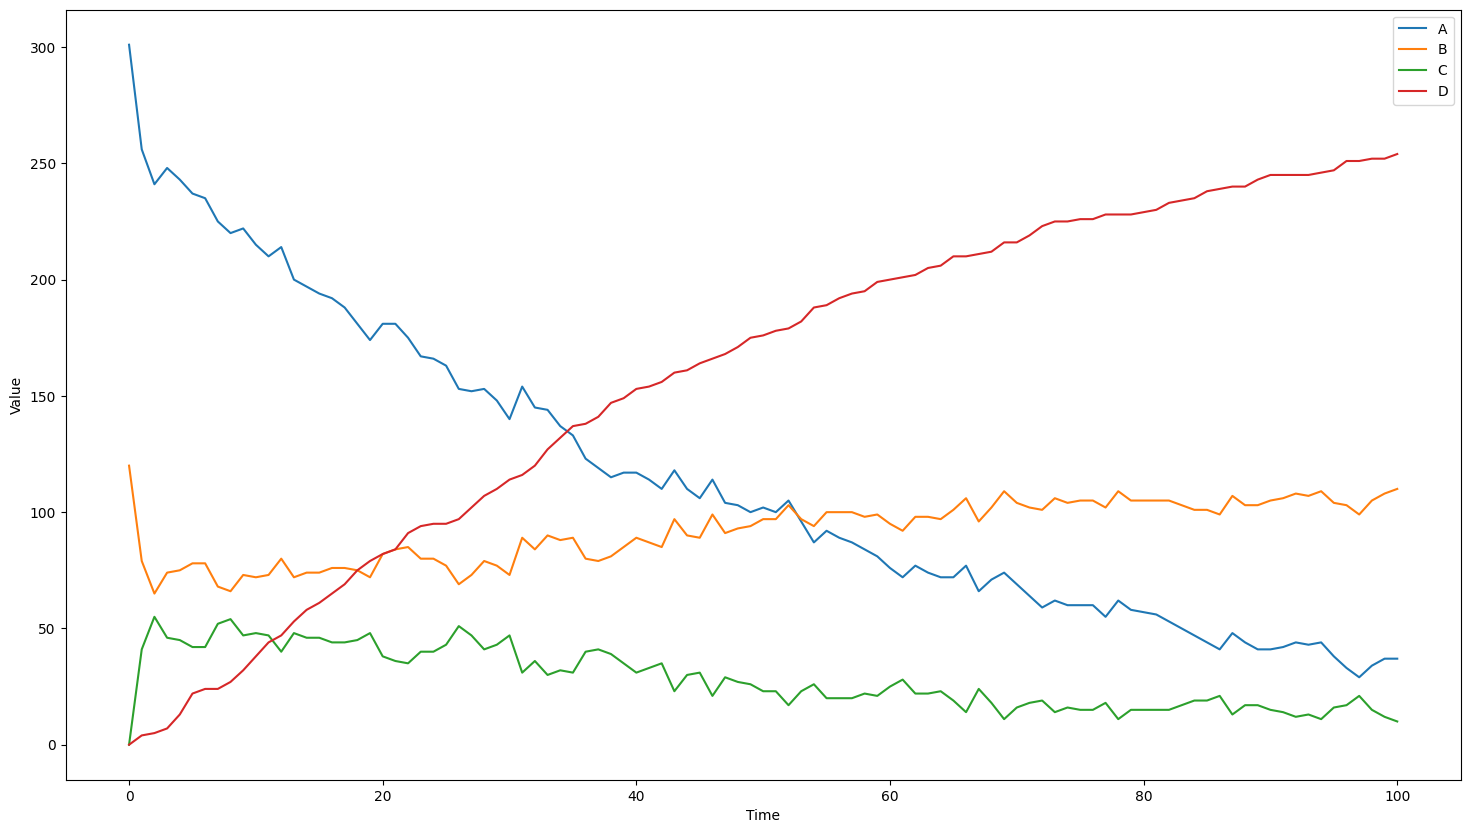

In [16]:
result.plot()

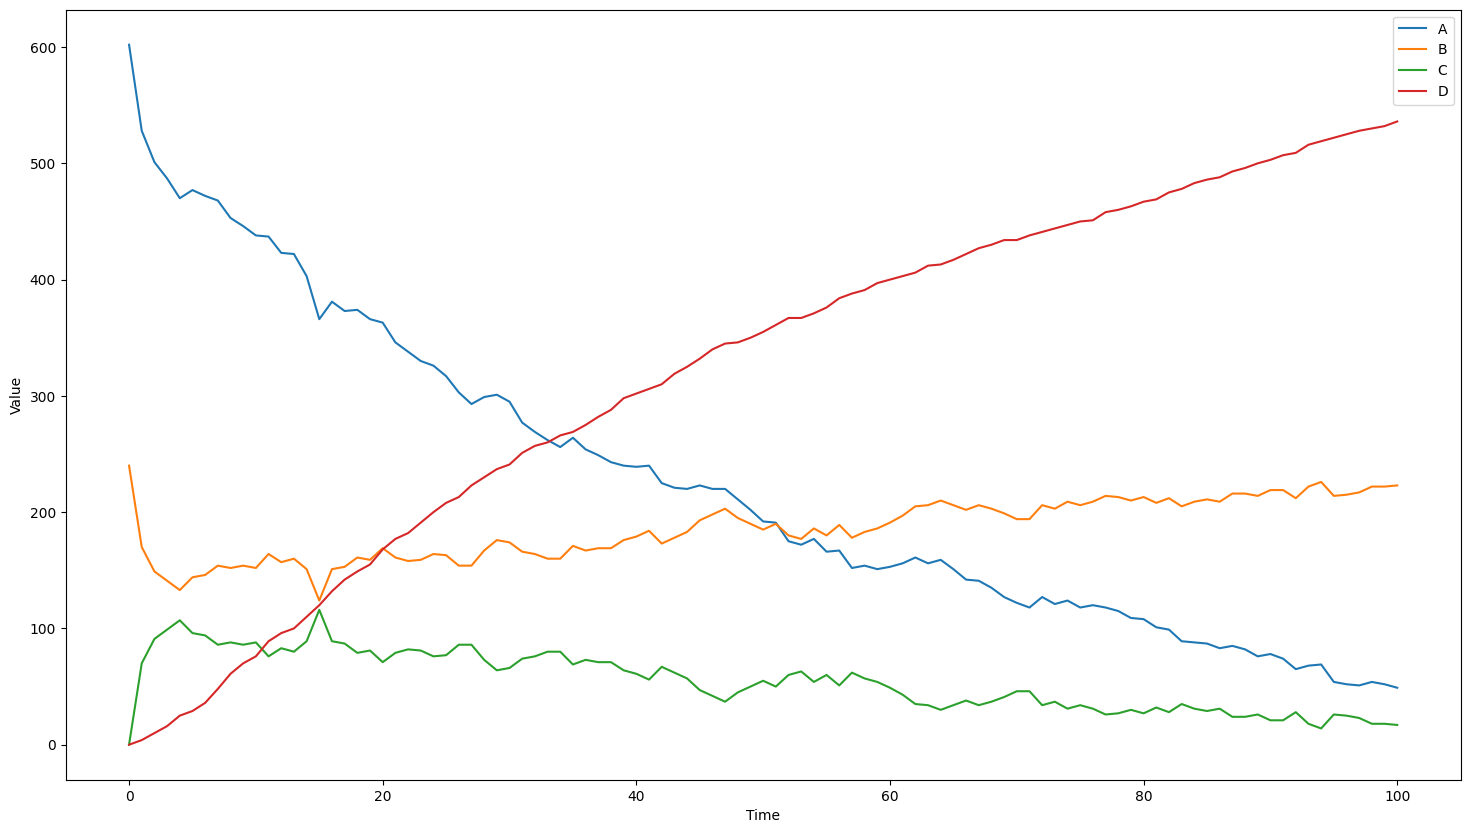

In [17]:
result2.plot()

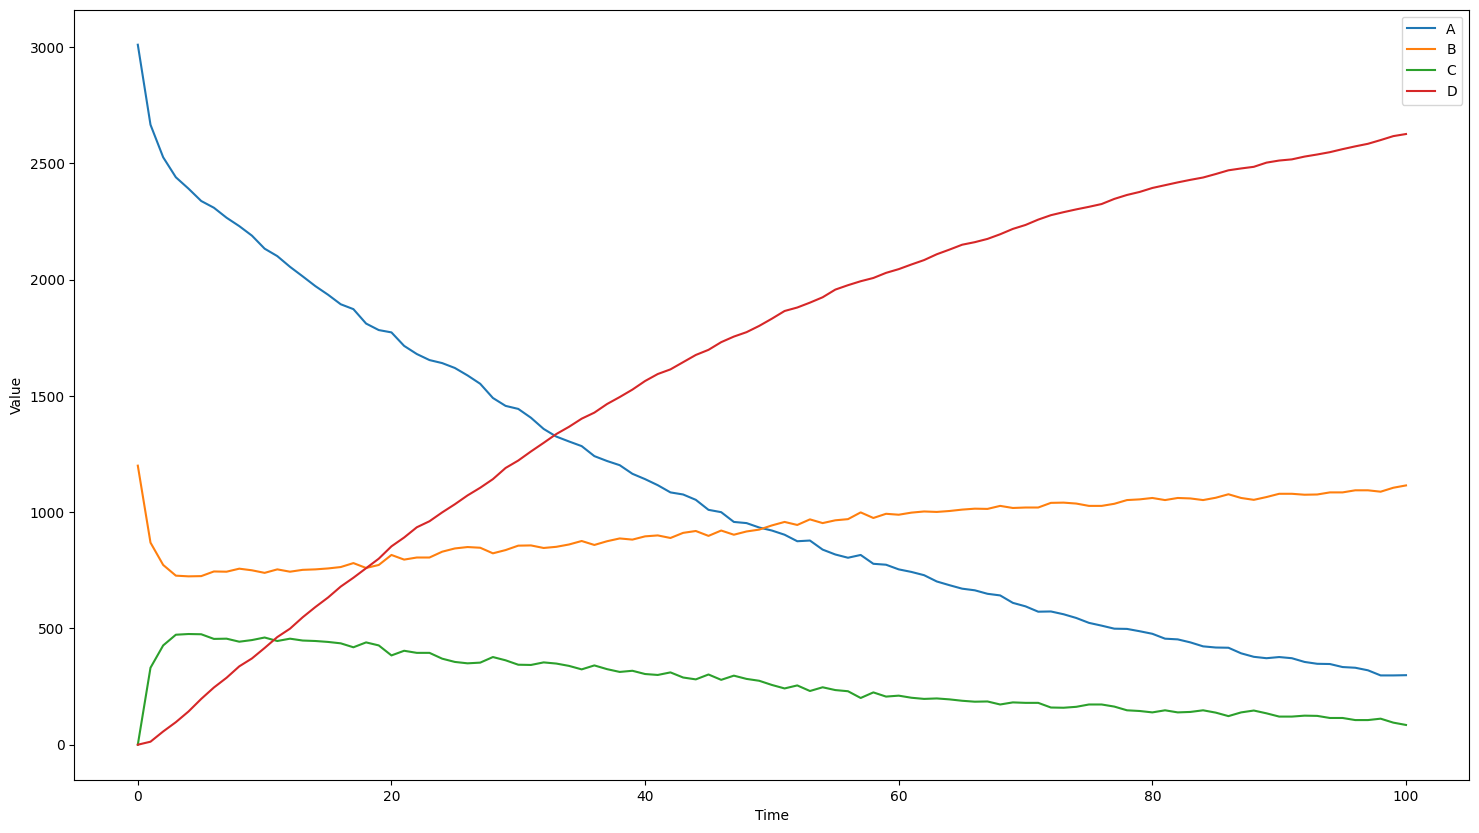

In [18]:
result10.plot()

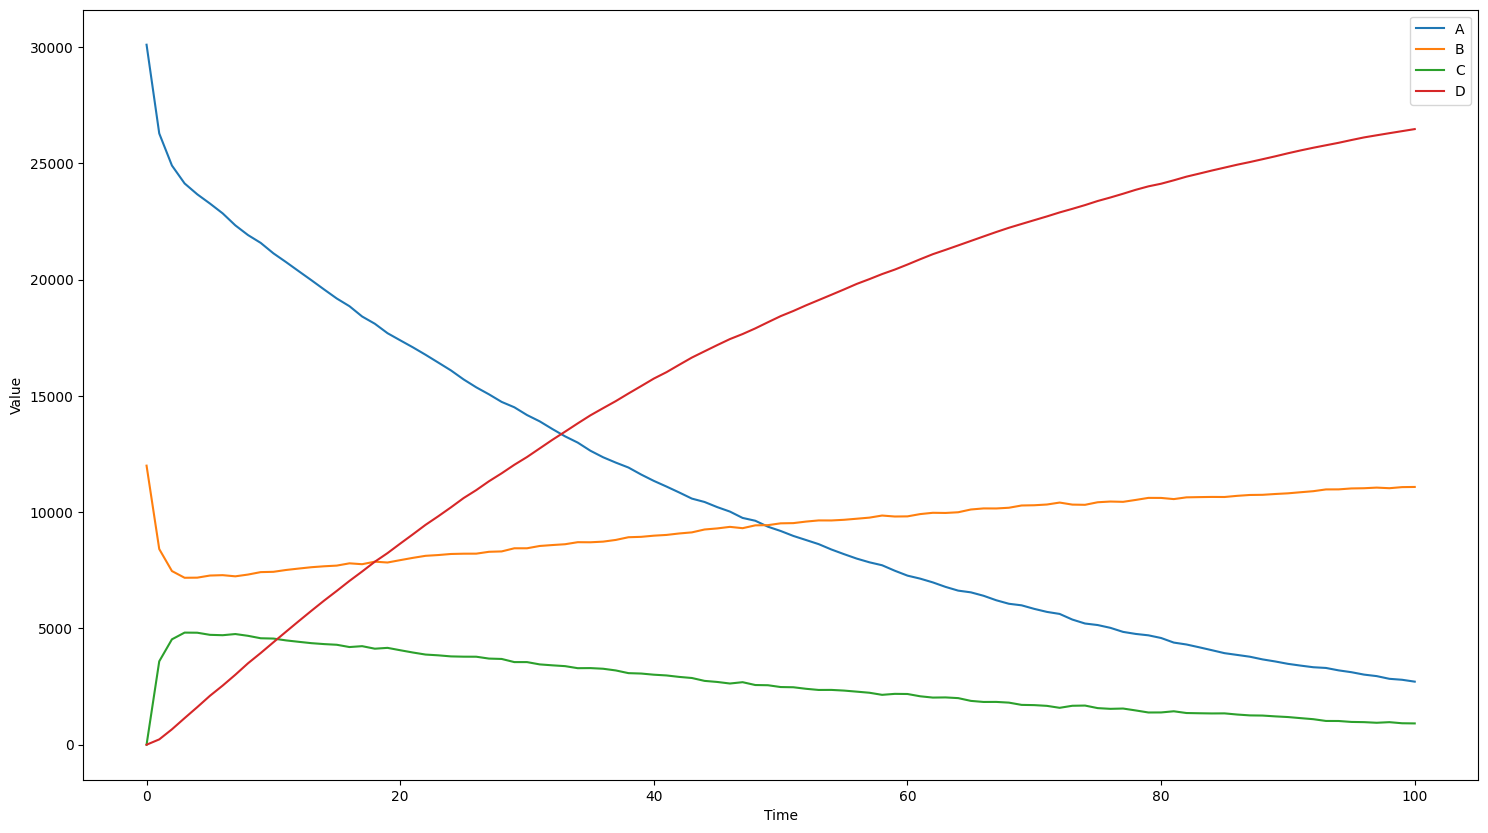

In [19]:
result100.plot()

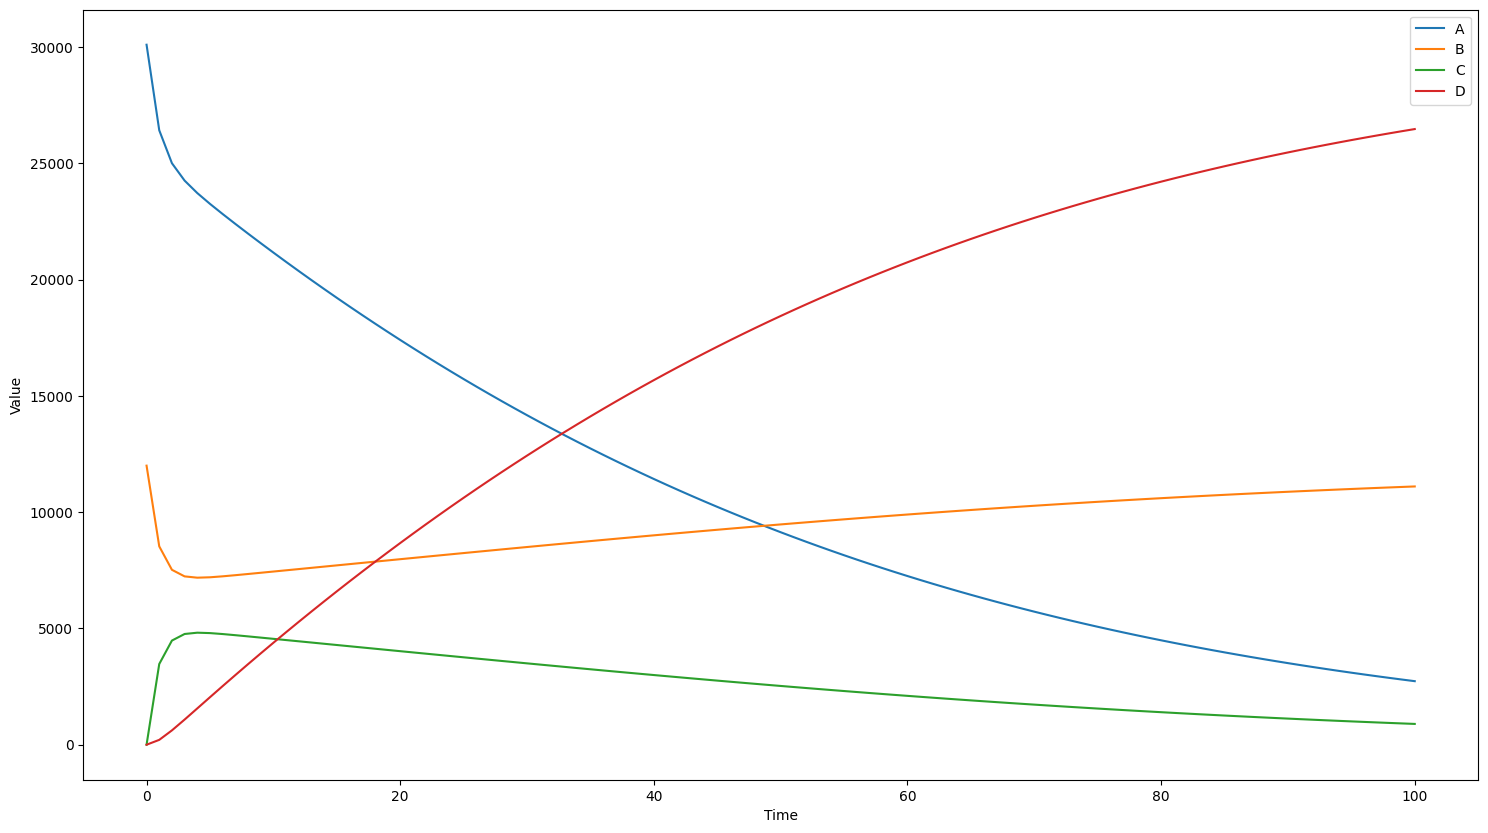

In [20]:
dresult100.plot()

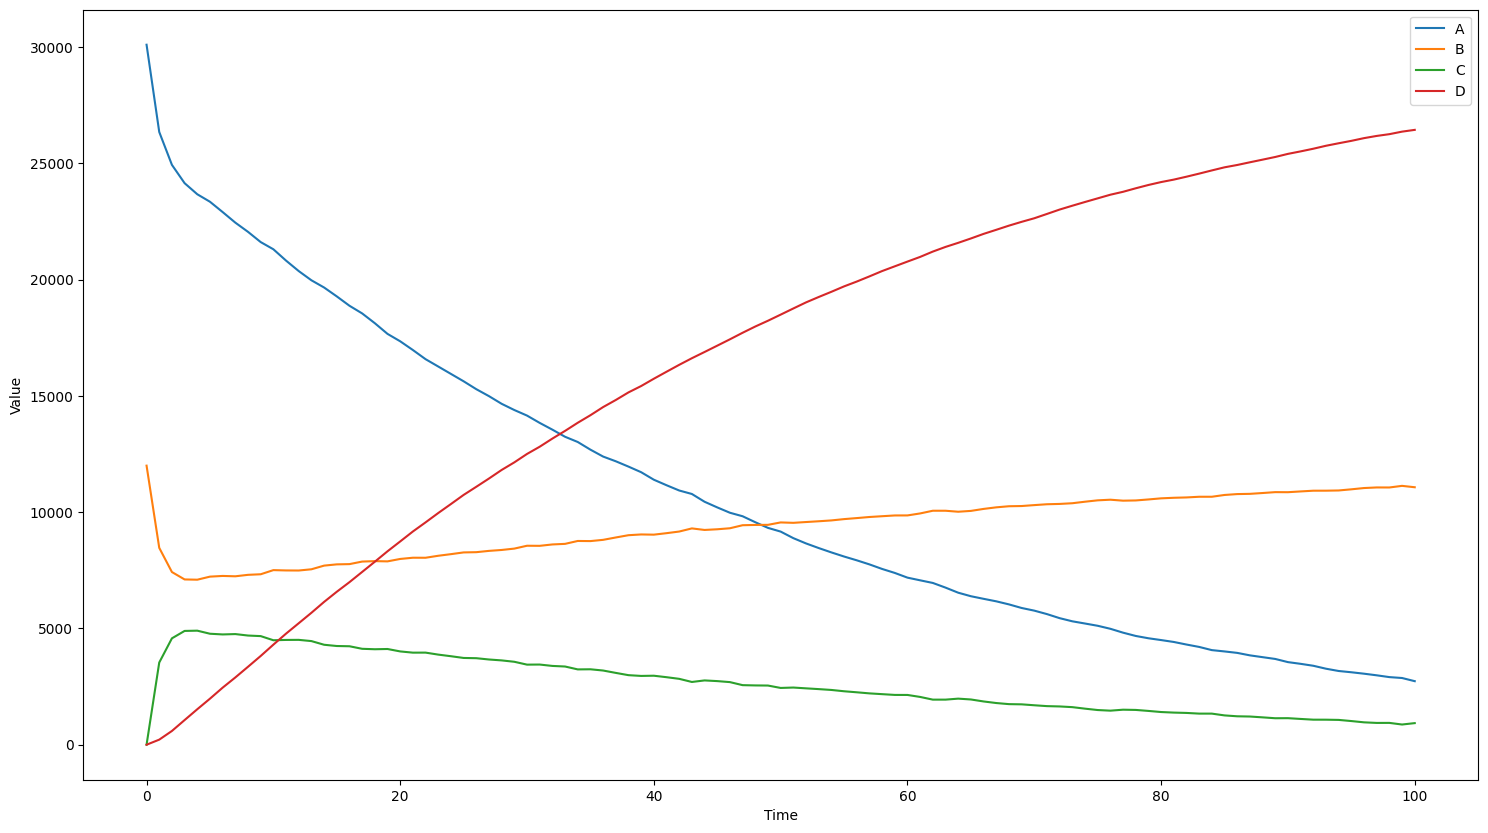

In [21]:
cresult100.plot()

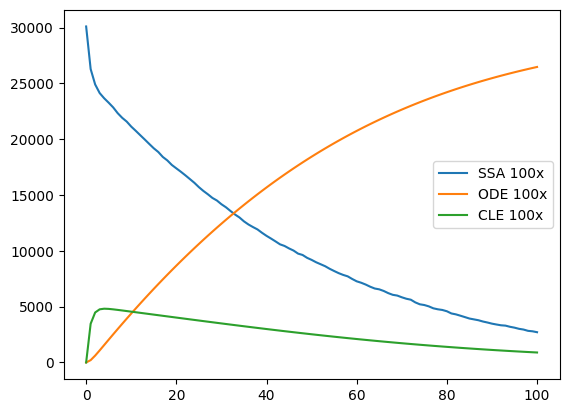

In [22]:
plt.plot(result100['time'], result100['A'], label='SSA 100x')
plt.plot(dresult100['time'], dresult100['D'], label='ODE 100x')
plt.plot(cresult100['time'], dresult100['C'], label='CLE 100x')
plt.legend(loc='best')

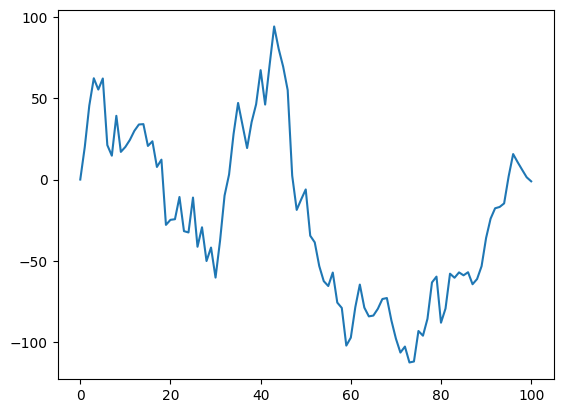

In [23]:
plt.plot(result100['time'], (result100['D'] - dresult100['D']))

## Run Convergence Study

In [24]:
def ode_cle_ssa_distance(n):
    m = build_michaelis_menten(scaling=n)
    s = m.run(algorithm="SSA")
    c = m.run(algorithm="CLE")
    o = m.run(algorithm="ODE")
    #sc= abs(numpy.max((s['D']-c['D'])))
    #so= abs(numpy.max((s['D']-o['D'])))
    #co= abs(numpy.max((c['D']-o['D'])))
    sc= scipy.linalg.norm(s['D']/n - c['D']/n)
    so= scipy.linalg.norm(s['D']/n - o['D']/n)
    co= scipy.linalg.norm(c['D']/n - o['D']/n)
    return {'sc':sc,'so':so,'co':co,'s':s,'c':c,'o':o}

def plot_d(d):
    for l in ['sc','so','co']:
        print(f"{l}: {d[l]}")
    for l in ['s','c','o']:
        plt.plot(d[l]['time'],d[l]['D'], label=l)
    plt.legend(loc='best')


In [25]:
%time d = ode_cle_ssa_distance(100)

CPU times: user 66.6 ms, sys: 21.1 ms, total: 87.7 ms
Wall time: 5.05 s


sc: 3.953551196347935
so: 4.530123553778637
co: 4.835395690582404


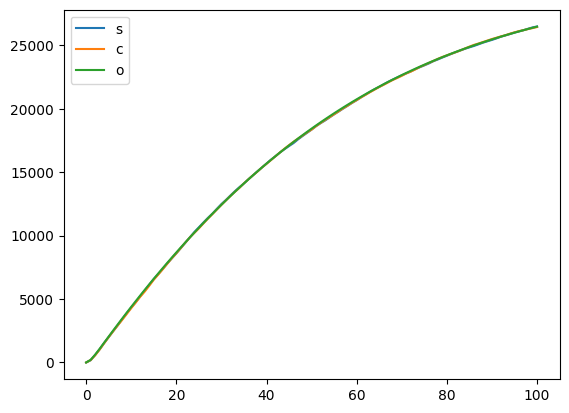

In [26]:
plot_d(d)

CPU times: user 82 ms, sys: 27.9 ms, total: 110 ms
Wall time: 6.19 s
sc: 1.0153743125736197
so: 0.33962285803522685
co: 1.1744528386845243


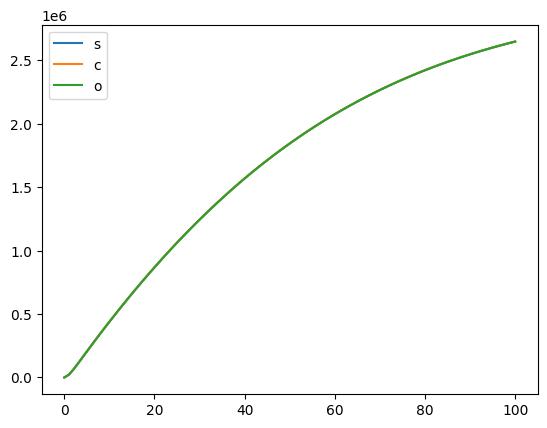

In [27]:
%time d5 = ode_cle_ssa_distance(10000)
plot_d(d5)

In [28]:
nlist=[10, 50, 100, 500, 1000, 5000, 10000]
def convergence_study():  
    global nlist
    clist = []
    for n in nlist:
        print(f"n={n}")
        clist.append(ode_cle_ssa_distance(n))
    return clist

In [29]:
%time clist = convergence_study()

n=10
n=50
n=100
n=500
n=1000
n=5000
n=10000
CPU times: user 398 ms, sys: 143 ms, total: 541 ms
Wall time: 36.3 s


sc=[37.21803473165075, 9.435782431922169, 12.680388316541165, 3.3413730637444194, 2.5999366929286576, 2.1479790680621487, 0.8838593033384821]
so=[17.572920729696616, 7.916404491838453, 9.570692681958832, 4.872118237112055, 1.6126194661171538, 1.1014422394297458, 0.2855711254661304]
co=[21.275254584273068, 4.743170884752039, 4.79094993385982, 4.946982443608577, 1.5213400871350344, 1.428202518751898, 0.6744514359179667]


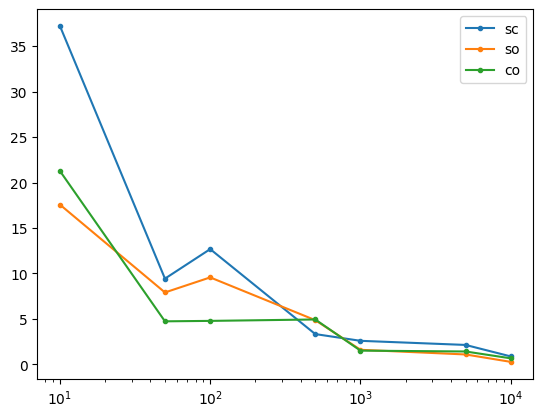

In [30]:
sc=[]
so=[]
co=[]
for c in clist:
    sc.append(c['sc'])
    so.append(c['so'])
    co.append(c['co'])
plt.semilogx(nlist,sc,'.-',label='sc')
print(f"sc={sc}")
plt.semilogx(nlist,so,'.-',label='so')
print(f"so={so}")
plt.semilogx(nlist,co,'.-',label='co')
print(f"co={co}")
plt.legend(loc='best')